In [1]:
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

In [2]:
import chainer
import chainer.functions as F
import chainer.links as L
from chainer import training
from chainer.training import extensions

# Network definition
class MLP(chainer.Chain):

    def __init__(self, n_units, n_out):
        super(MLP, self).__init__()
        with self.init_scope():
            # the size of the inputs to each layer will be inferred
            self.l1 = L.Linear(None, n_units)  # n_in -> n_units
            self.l2 = L.Linear(None, n_units)  # n_units -> n_units
            self.l3 = L.Linear(None, n_out)  # n_units -> n_out

    def forward(self, x):
        h1 = F.relu(self.l1(x))
        h2 = F.relu(self.l2(h1))
        return self.l3(h2)


In [3]:
gpuid = 0
model = L.Classifier(MLP( 500 , 10))

#GPU
chainer.backends.cuda.get_device_from_id( 0 ).use()
model.to_gpu()  # Copy the model to the GPU

In [4]:
import math
import warnings

import numpy as np

from chainer import backend
from chainer.backends import cuda
from chainer.backends import intel64
from chainer import optimizer
from chainer import Variable
import chainer.functions as F

_default_hyperparam = optimizer.Hyperparameter()
_default_hyperparam.epsilon = 0.1
_default_hyperparam.delta = 0.95


class HamiltonianRule(optimizer.UpdateRule):
    
    """ Update rule of Hamiltonian Gradient Descent.
    
    sample ver.
    """
    
    _kernel = None
    
    def __init__(self, parent_hyperparam=None,
                 epsilon=None, delta=None, body=None, tail=None, expon=None):
        super(HamiltonianRule, self).__init__(
            parent_hyperparam or _default_hyperparam)
        if epsilon is not None:
            self.hyperparam.epsilon = epsilon
        if delta is not None:
            self.hyperparam.delta = delta
            
    def init_state(self, param):
        xp = backend.get_array_module(param.data)
        with cuda.get_device_from_array(param.data):
            self.state['p'] = xp.zeros_like(param.data)
        
        
    def update_core_cpu(self, param):
        grad = param.grad
        if grad is None:
            return
        hp = self.hyperparam
        p = self.state['p']
        
        p_ip1 = hp.delta * p - hp.epsilon * hp.delta * grad
        
        p_ip1var = Variable(p_ip1)
        
        sqsum = chainer.functions.sum(p_ip1var ** 2.0)
        kinetic = (1+ sqsum) ** 0.5-1
        
        kinetic.backward()
        grad_k = p_ip1var.grad
        
        p = p_ip1
        param.data += hp.epsilon * grad_k
        
     
    def update_core_gpu(self, param):
        grad = param.grad
        if grad is None:
            return
        hp = self.hyperparam
        p = self.state['p']
        
        p_ip1 = hp.delta * p - hp.epsilon * hp.delta * grad
        
        p_ip1var = Variable(p_ip1)

        sqsum = chainer.functions.sum(p_ip1var ** 2.0)
        kinetic = (1+ sqsum ) ** 0.5-1
        
        kinetic.backward()
        grad_k = p_ip1var.grad
        
        p = p_ip1
        param.data += hp.epsilon * grad_k
        

class Hamiltonian(optimizer.GradientMethod):
    def __init__(self,
                  epsilon=_default_hyperparam.epsilon,
                  delta=_default_hyperparam.delta):
        
        super(Hamiltonian, self).__init__()
        self.hyperparam.epsilon = epsilon
        self.hyperparam.delta = delta
        
    epsilon = optimizer.HyperparameterProxy('epsilon')
    delta = optimizer.HyperparameterProxy('delta')
    
    def create_update_rule(self):
        return HamiltonianRule(self.hyperparam)
        

In [5]:
gpuid = 0
model = L.Classifier(MLP( 500 , 10))

#GPU
chainer.backends.cuda.get_device_from_id( 0 ).use()
model.to_gpu()  # Copy the model to the GPU

optimizer = Hamiltonian(epsilon=1, delta=.6)
optimizer.setup(model)

# Load the MNIST dataset
train, test = chainer.datasets.get_mnist()

train_iter = chainer.iterators.SerialIterator(train, 100)
test_iter = chainer.iterators.SerialIterator(test, 100, repeat=False, shuffle=False)

# Set up a trainer
updater = training.updaters.StandardUpdater( train_iter, optimizer, device=0)
trainer = training.Trainer(updater, (100, 'epoch'))

# Evaluate the model with the test dataset for each epoch
trainer.extend(extensions.Evaluator(test_iter, model, device=0))

trainer.extend(extensions.dump_graph('main/loss'))
#frequency = 10
#trainer.extend(extensions.snapshot(), trigger=(frequency, 'epoch'))
trainer.extend(extensions.LogReport(log_name="Hamiltonian"))
trainer.extend(extensions.PrintReport(['epoch', 'main/loss', 'validation/main/loss', 'main/accuracy', 'validation/main/accuracy', 'elapsed_time']))


In [6]:
trainer.run()

epoch       main/loss   validation/main/loss  main/accuracy  validation/main/accuracy  elapsed_time
1           0.261474    0.114396              0.919033       0.9651                    7.51482       
2           0.0882276   0.0827815             0.972133       0.9733                    14.3697       
3           0.0586765   0.0821963             0.981032       0.9756                    21.1871       
4           0.0406741   0.0809706             0.987382       0.9771                    27.9756       
5           0.0273404   0.0718886             0.991565       0.9794                    34.7968       
6           0.018122    0.0761455             0.994832       0.9792                    41.6265       
7           0.0146153   0.0740107             0.995432       0.9806                    48.4827       
8           0.0110674   0.0691819             0.996699       0.9817                    55.3176       
9           0.00801042  0.0626532             0.997433       0.9835                 

78          2.75201e-05  0.0811515             1              0.985                     538.944       
79          2.716e-05   0.0813174             1              0.9849                    545.84        
80          2.67724e-05  0.0813802             1              0.985                     552.73        
81          2.64083e-05  0.0815284             1              0.985                     559.656       
82          2.60107e-05  0.081679              1              0.9848                    566.55        
83          2.56897e-05  0.0817617             1              0.9849                    573.445       
84          2.53364e-05  0.0818674             1              0.9848                    580.341       
85          2.49818e-05  0.0819904             1              0.9849                    587.212       
86          2.46511e-05  0.0821289             1              0.9851                    594.125       
87          2.43447e-05  0.0821366             1              0.985       

In [7]:
hamiltonian_result = pd.read_json("./result/Hamiltonian")
hamiltonian_result

,elapsed_time,epoch,iteration,main/accuracy,main/loss,validation/main/accuracy,validation/main/loss
0,7.514824,1,600,0.919033,0.261474,0.9651,0.114396
1,14.369650,2,1200,0.972133,0.088228,0.9733,0.082781
2,21.187146,3,1800,0.981032,0.058676,0.9756,0.082196
3,27.975579,4,2400,0.987382,0.040674,0.9771,0.080971
4,34.796805,5,3000,0.991565,0.027340,0.9794,0.071889
5,41.626520,6,3600,0.994832,0.018122,0.9792,0.076146
6,48.482683,7,4200,0.995432,0.014615,0.9806,0.074011
7,55.317596,8,4800,0.996699,0.011067,0.9817,0.069182
8,62.118285,9,5400,0.997433,0.008010,0.9835,0.062653
9,68.953067,10,6000,0.999083,0.003880,0.9834,0.068947


In [8]:
gpuid = 0
model = L.Classifier(MLP( 500 , 10))

#GPU
chainer.backends.cuda.get_device_from_id( 0 ).use()
model.to_gpu()  # Copy the model to the GPU

optimizer = chainer.optimizers.Adam()
optimizer.setup(model)

# Load the MNIST dataset
train, test = chainer.datasets.get_mnist()

train_iter = chainer.iterators.SerialIterator(train, 100)
test_iter = chainer.iterators.SerialIterator(test, 100, repeat=False, shuffle=False)

# Set up a trainer
updater = training.updaters.StandardUpdater( train_iter, optimizer, device=0)
trainer = training.Trainer(updater, (100, 'epoch'))

# Evaluate the model with the test dataset for each epoch
trainer.extend(extensions.Evaluator(test_iter, model, device=0))

trainer.extend(extensions.dump_graph('main/loss'))
#frequency = 10
#trainer.extend(extensions.snapshot(), trigger=(frequency, 'epoch'))
trainer.extend(extensions.LogReport(log_name="Adam"))
trainer.extend(extensions.PrintReport(['epoch', 'main/loss', 'validation/main/loss', 'main/accuracy', 'validation/main/accuracy', 'elapsed_time']))


#trainer.extend(extensions.ProgressBar())

In [9]:
trainer.run()

epoch       main/loss   validation/main/loss  main/accuracy  validation/main/accuracy  elapsed_time
1           0.220448    0.107116              0.935233       0.9683                    2.50615       
2           0.0800231   0.0709073             0.975333       0.9766                    5.00697       
3           0.0528217   0.0708251             0.983199       0.9782                    7.49511       
4           0.038376    0.0685852             0.987598       0.9797                    9.99217       
5           0.0286297   0.0724988             0.990565       0.9783                    12.4834       
6           0.0246755   0.0751434             0.991598       0.9778                    14.9714       
7           0.020978    0.0799223             0.992898       0.9776                    17.4576       
8           0.0178527   0.0830112             0.993699       0.9809                    19.9576       
9           0.0147695   0.104693              0.994932       0.9738                 

79          0.00267539  0.196485              0.999433       0.9827                    194.756       
80          0.00355553  0.197051              0.999183       0.9833                    197.209       
81          0.00335038  0.204266              0.999316       0.9825                    199.65        
82          0.00468083  0.203816              0.999316       0.9817                    202.1         
83          0.00546319  0.184978              0.999116       0.9825                    204.543       
84          0.00205196  0.198838              0.9996         0.9828                    206.977       
85          0.00119621  0.204371              0.9997         0.9819                    209.415       
86          0.00705691  0.220094              0.998616       0.9827                    211.86        
87          0.00550432  0.187574              0.998833       0.9833                    214.324       
88          0.00464033  0.186954              0.999216       0.9835               

In [10]:
#renamed manually
adam_result = pd.read_json("./result/Adam")

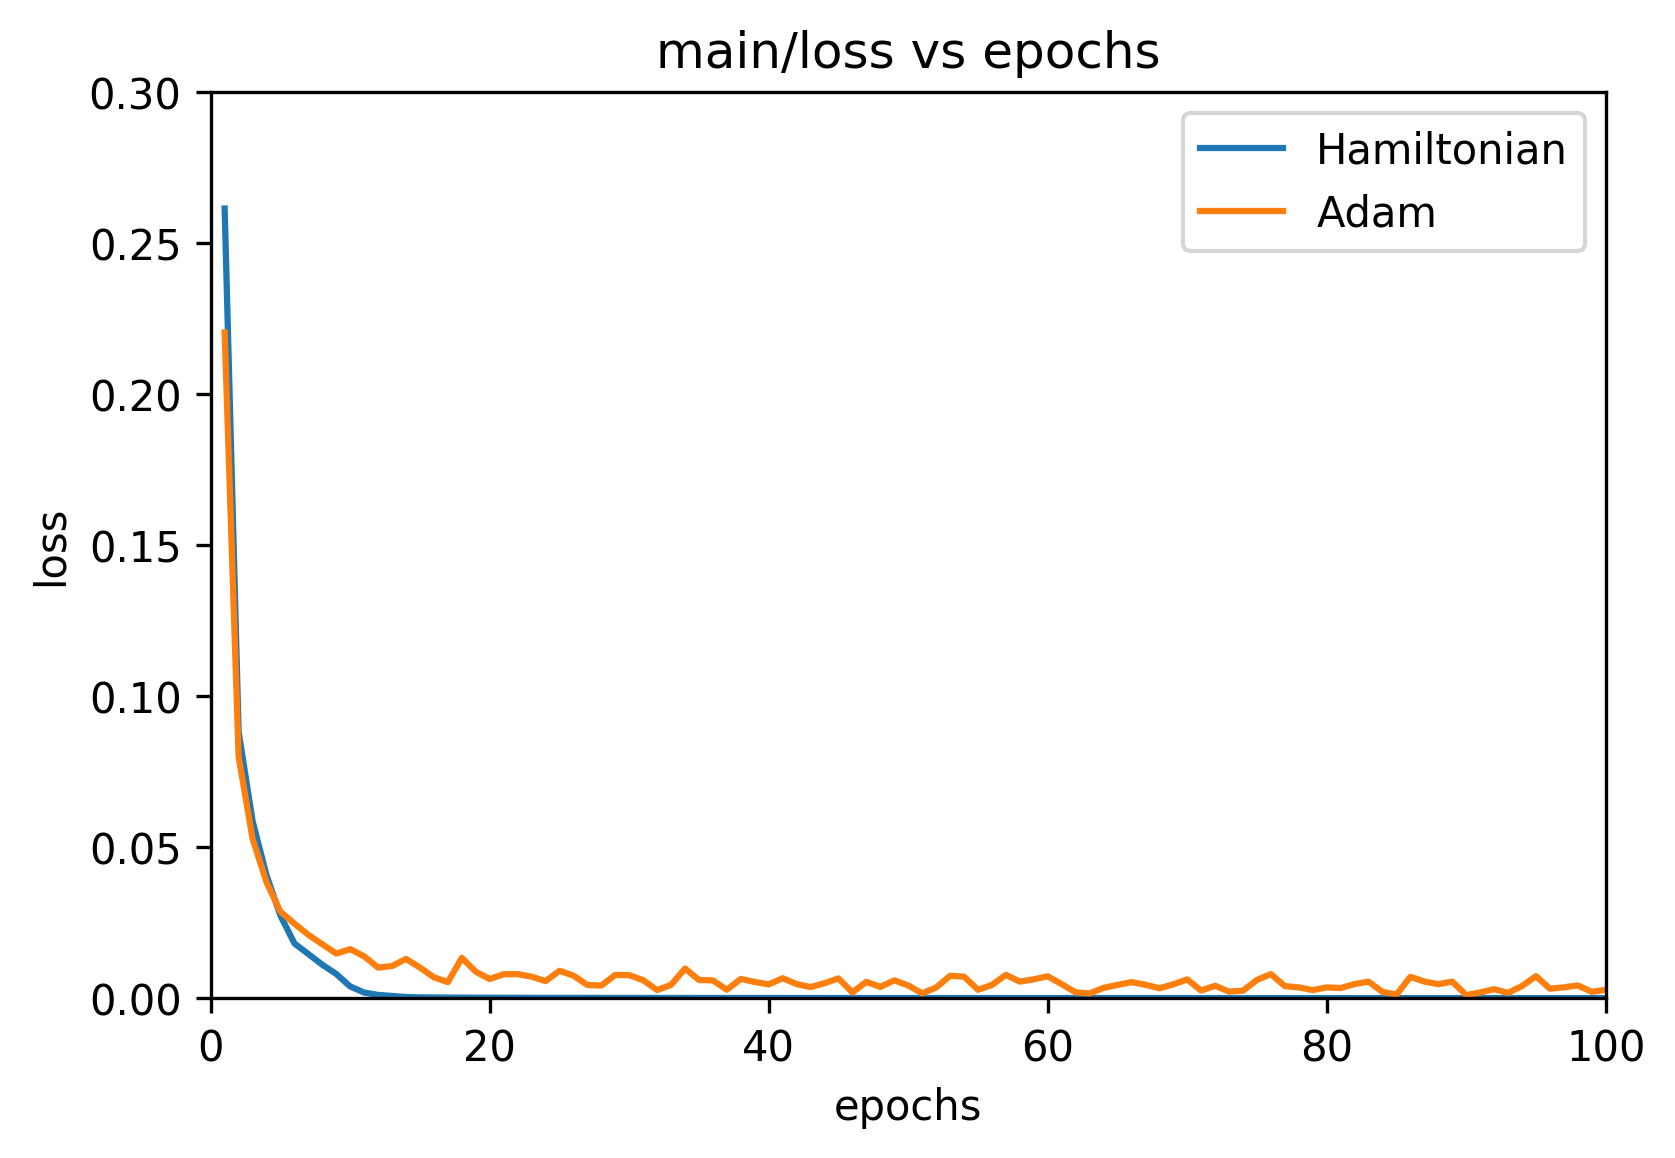

In [11]:
plt.figure(figsize=(6,4),dpi=300)
plt.ylim(0,.3)
plt.xlim(0,100)
plt.title("main/loss vs epochs")
plt.xlabel("epochs")
plt.ylabel("loss")
plt.plot(hamiltonian_result["epoch"],hamiltonian_result["main/loss"], label='Hamiltonian')
plt.plot(adam_result["epoch"],adam_result["main/loss"], label='Adam')


plt.legend()

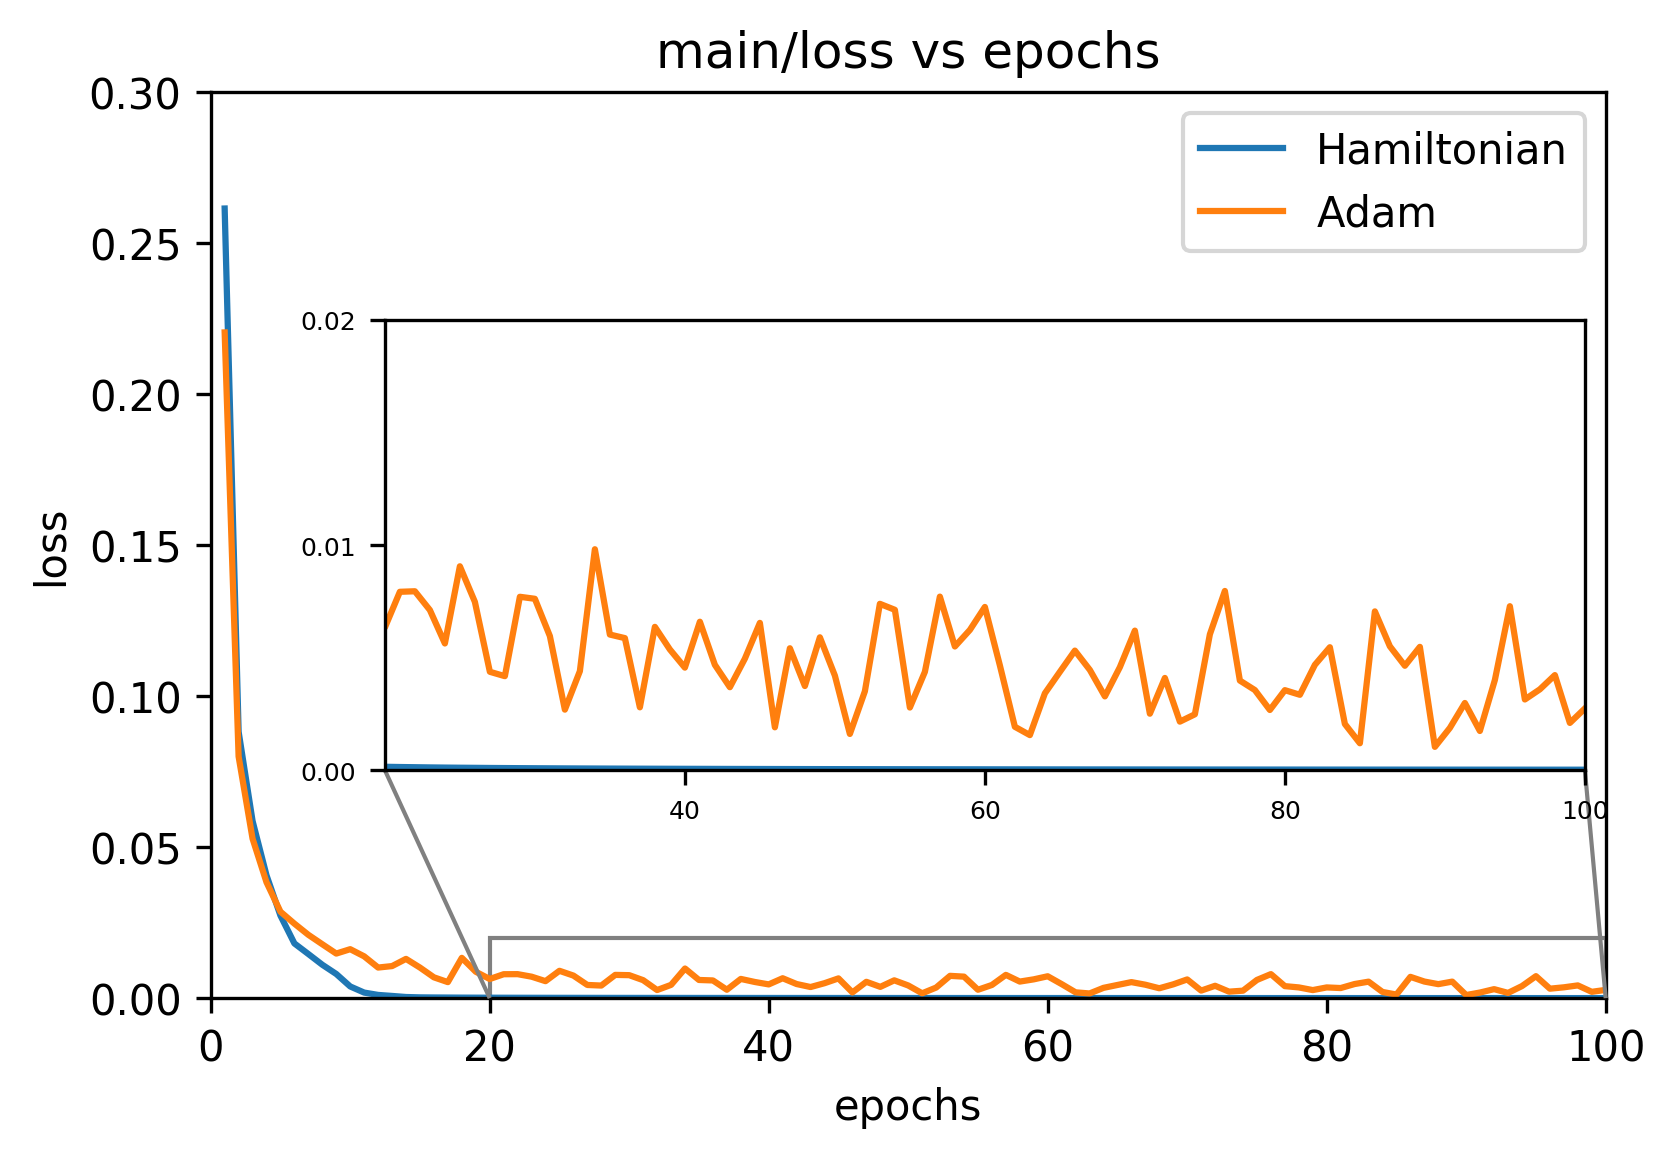

In [12]:
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from mpl_toolkits.axes_grid1.inset_locator import mark_inset

fig, ax = plt.subplots(figsize=(6,4),dpi=300)
plt.title("main/loss vs epochs")
plt.xlabel("epochs")
plt.ylabel("loss")
plt.ylim(0,.3)
plt.xlim(0,100)

axins = inset_axes(ax, 4,1.5 , loc=5)
axins.set_xlim(20,100)
axins.set_ylim(0,.02)

ax.plot(hamiltonian_result["epoch"],hamiltonian_result["main/loss"], label='Hamiltonian')
ax.plot(adam_result["epoch"],adam_result["main/loss"], label='Adam')

axins.plot(hamiltonian_result["epoch"],hamiltonian_result["main/loss"], label='Hamiltonian')
axins.plot(adam_result["epoch"],adam_result["main/loss"], label='Adam')

plt.xticks([40,60,80,100],fontsize=6)
plt.yticks([0,.01,.02],fontsize=6)
mark_inset(ax, axins, loc1=4, loc2=3, fc="none", ec="0.5")

ax.legend(loc=1)


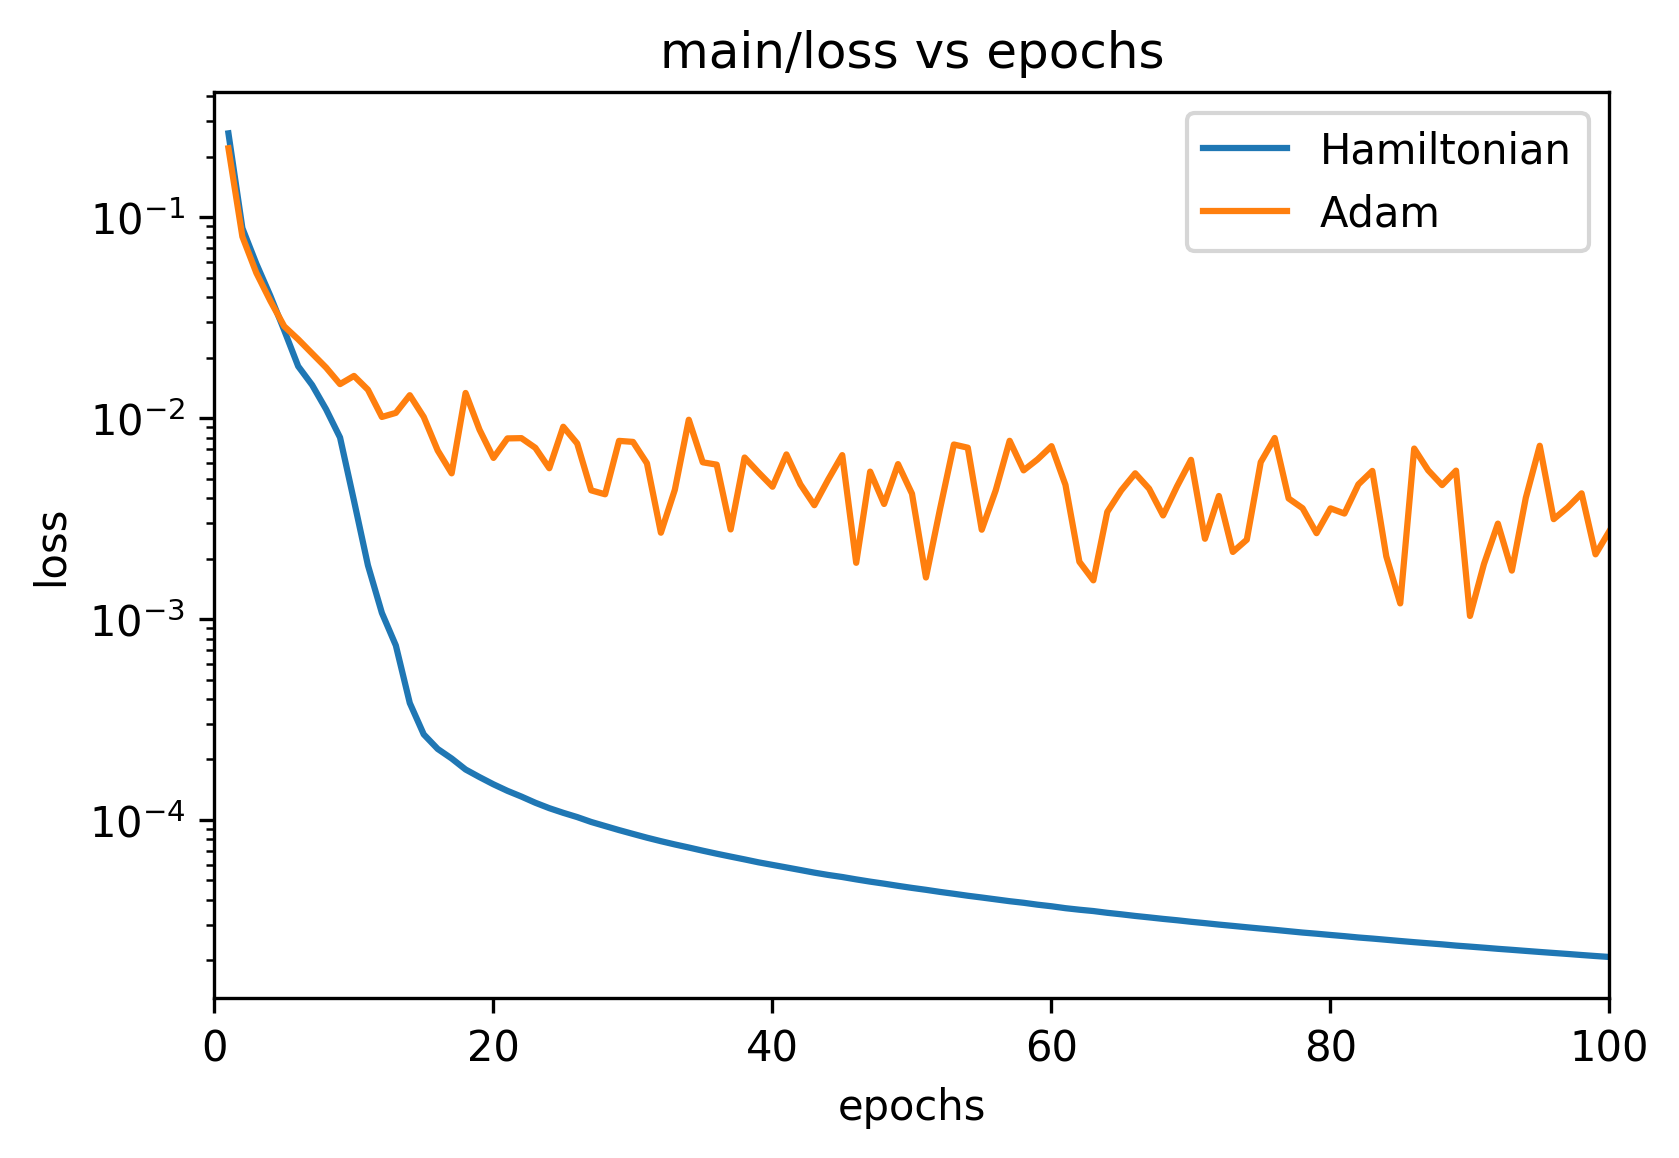

In [13]:
plt.figure(figsize=(6,4),dpi=300)
plt.yscale("log")
plt.xlim(0,100)
plt.title("main/loss vs epochs")
plt.xlabel("epochs")
plt.ylabel("loss")
plt.plot(hamiltonian_result["epoch"],hamiltonian_result["main/loss"], label='Hamiltonian')
plt.plot(adam_result["epoch"],adam_result["main/loss"], label='Adam')


plt.legend()

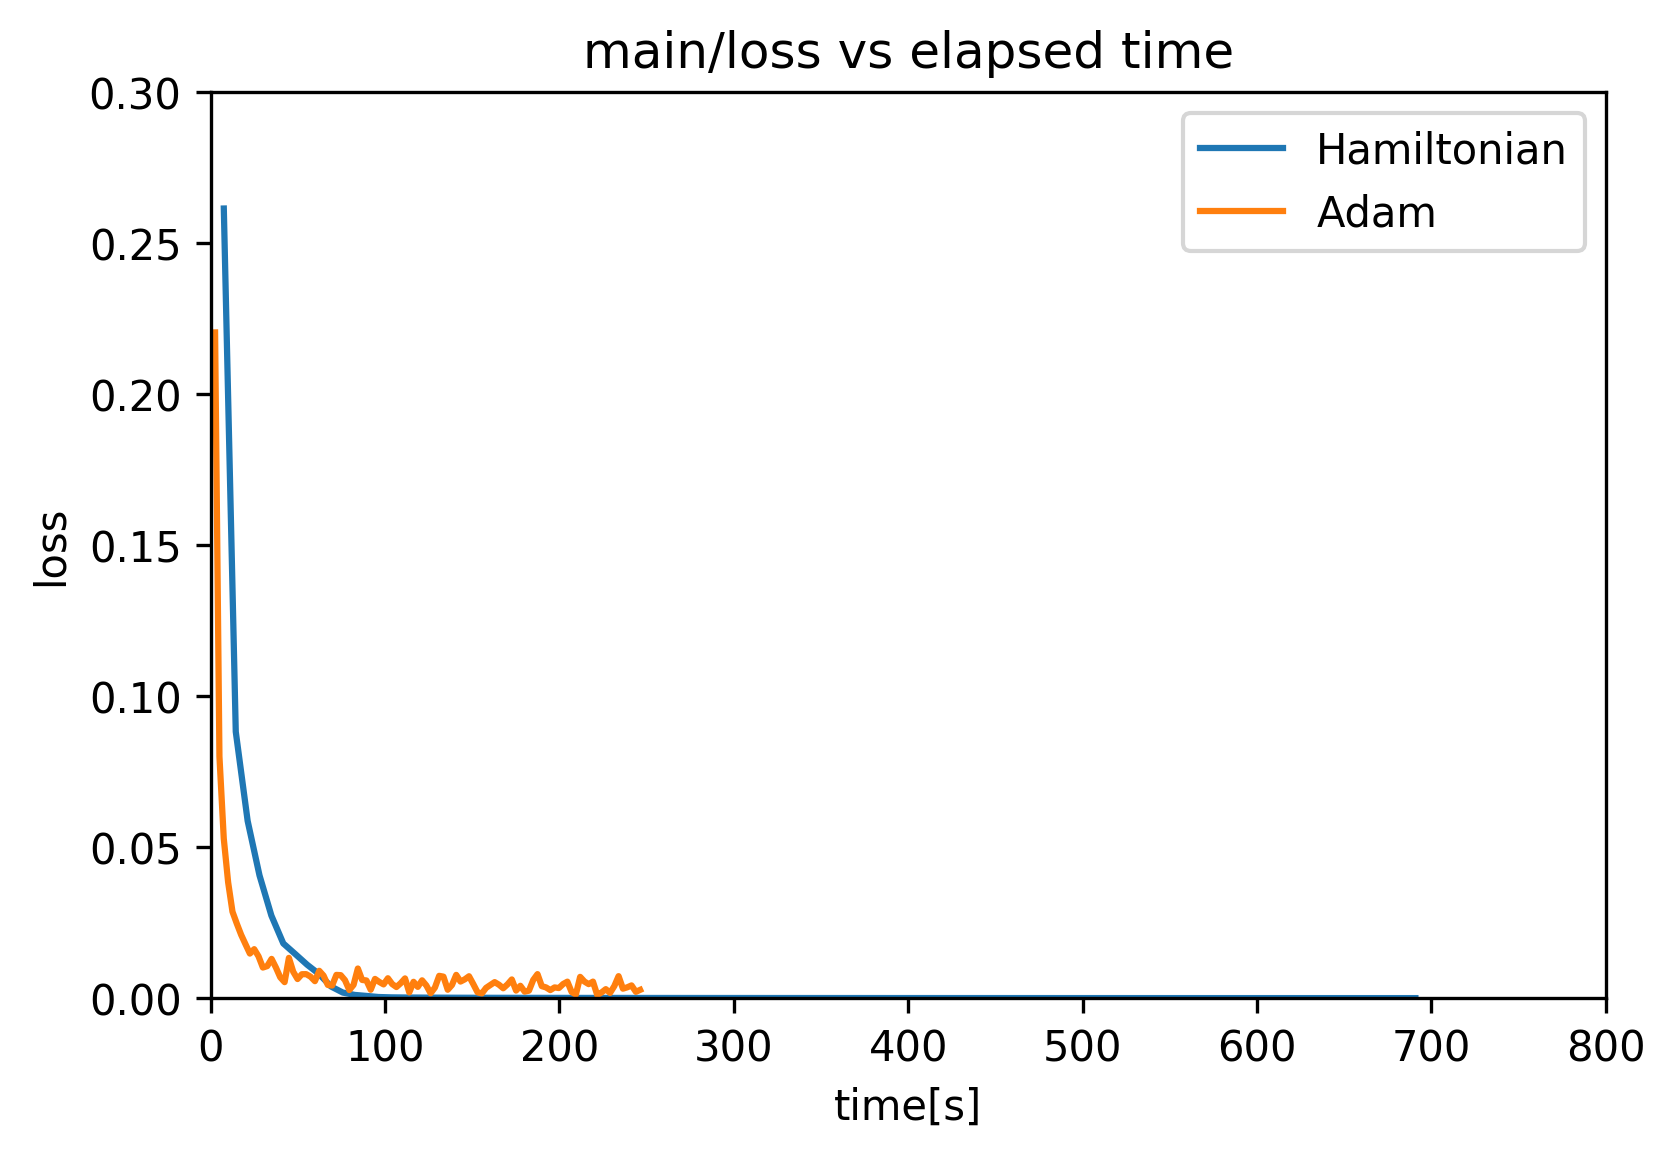

In [14]:
plt.figure(figsize=(6,4),dpi=300)
plt.ylim(0,.3)
plt.xlim(0,800)
plt.title("main/loss vs elapsed time")
plt.xlabel("time[s]")
plt.ylabel("loss")
plt.plot(hamiltonian_result["elapsed_time"],hamiltonian_result["main/loss"], label='Hamiltonian')
plt.plot(adam_result["elapsed_time"],adam_result["main/loss"], label='Adam')


plt.legend()